In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

rseed = 20090425

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Import and clean data

In [2]:
data_file = 'data/Bleeding_Dataonly_For Chris_04182016.xlsx'

raw_data = (pd.read_excel(data_file, sheetname='Bleeding_Outcomes_AllKQs',
                         na_values=['null', 'ND'])
            .drop(['Comments', 'Other stats \nName','Other Stats','Results','Comments 2',
                   'Presentation \nlocation','Last Assesment tmpt for the study','Followup duration category'], 
                  axis=1)
            .rename(columns={'Outcome timepoint (when was this outcome measured, e.g., in PACU, 12 months post─op, immediately post─op──would need a row for each outcome at each timepoint of interest)': 'outcome_time',
                             'OUTC_Main_\nCATG':'outcome_cat',
                            "Outc_SUB_\nCATG":'outcome_subcat',
                            'OUTCOME SAMPLE SIZE': 'N',
                             'Outcome\ncount': 'outcome_obs',
                            'Outcome  \n%': 'outcome_pct',
                            "Outcome\n Mean": 'outcome_mean',
                            "Outcome \nSD": 'outcome_sd',
                             'Outcome \n SE': 'outcome_se',
                             'Outcome\n _Q1': 'outcome_q1', 
                             'Outcome \n_Q3': 'outcome_q3',
                            "Outcome \n Median": 'outcome_med',
                            "Outcome \n 95% L": 'outcome_lo_95',
                            "Outcome \n 95% H": 'outcome_hi_95',
                            "Outcome\n  Min": 'outcome_min', 
                             'Outcome \n Max': 'outcome_max'}))

raw_data.head()

,Citation,REFID,Child Paper,Number of Arms,Rx Grouping,Group_Desc,Intervention_category,Dose,Route,Rx_Durn,...,outcome_mean,outcome_sd,outcome_se,outcome_med,outcome_q1,outcome_q3,outcome_min,outcome_max,outcome_lo_95,outcome_hi_95
0,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G1:,Celecoxib,Preoperative and postoperative NSAID,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.0,8.0
1,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G2:,Placebo,Placebo,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G1:,Celecoxib,Preoperative and postoperative NSAID,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,6.0
3,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G2:,Placebo,Placebo,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"H. S. Abdel-Ghaffar, H. G. Abdel-Azeem and M. ...",253,NaN,2,G1a:,Lornoxicam in one tonsil,perioperative NSAID,8 mg,Instillation/infiltration,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
exclude = 2170,3772,7389

In [5]:
raw_data['Intervention_category'] = raw_data.Intervention_category.str.lower().str.strip()[~raw_data.REFID.isin(exclude)]
clean_data = (raw_data.replace({'Intervention_category':{'saline':'control',
                        'control (no rx)':'control',
                        'control (no dexamethasone)':'control',
                        'no antibiotics':'control',
                        'no steroid':'control',
                        'placebo':'control'},
                        'REFID':{'11238_2480_2506_3102':'11238_2480_2506', 
                                  '1843_1437':'1437_1843', 
                                  '2071_362':'362_2071'}})
              .assign(study_id=raw_data.REFID.astype(str)))

In [6]:
risk_of_bias = (pd.read_excel(data_file, sheetname='ROB_Country_info',
                         na_values=['null', 'ND'])[['Refid', 'RoB']]
                )

In [7]:
clean_data.REFID[~clean_data.REFID.astype(str).isin(risk_of_bias.Refid.astype(str).unique())].unique()

array([2170, 3772, 7389], dtype=object)

In [8]:
merged_data = clean_data.merge(risk_of_bias.assign(study_id=risk_of_bias.Refid.astype(str)), 
                               on='study_id')

Counts of bleeding outcomes by major category

In [9]:
merged_data.New_Bleeding_specify.value_counts()

Reoperation-bleeding            157
Revisit/Readmission-bleeding    143
Undefined bleeding              113
Secondary bleeding              108
Primary bleeding                105
Name: New_Bleeding_specify, dtype: int64

Here is the full list of intervention categories. For the purposes of this analysis, I will just use the ones with "total" or "partial" in the name, and take them to be surgical interventions.

In [11]:
merged_data.Intervention_category.value_counts()

total cold                                                122
total electrocautery                                      118
total coblation                                            66
control                                                    48
perioperative steroid                                      47
total harmonic scalpel                                     28
partial coblation                                          21
total molecular resonance                                  20
perioperative nsaid                                        17
partial microdebrider                                      15
total laser                                                13
partial cold                                               13
partial laser                                              13
total thermal welding                                      12
postoperative analgesic                                     9
perioperative anesthetic                                    5
perioper

Here is the surgery filter:

In [21]:
surgery_data = merged_data[merged_data.Intervention_category.str.contains('total') 
                   | merged_data.Intervention_category.str.contains('partial')].dropna(subset=['outcome_obs']).copy()

List of interventions after filtering. Note that there were a lot of papers that did not report bleeding outcomes, so the numbers dropped significantly. 

In [22]:
surgery_data.Intervention_category.value_counts()

total cold                                             72
total electrocautery                                   66
total coblation                                        34
total harmonic scalpel                                 22
total molecular resonance                              13
partial laser                                          11
total thermal welding                                  10
partial coblation                                      10
partial cold                                            7
partial microdebrider                                   6
total laser                                             6
total adenotonsillectomy - unspecified + no surgery     3
total tonsillectomy - unspecified                       2
total microdebrider                                     1
partial electrocautery                                  1
total adenotonsillectomy - unspecified                  1
total not specified                                     1
total tonsille

Indicator for partial

In [23]:
surgery_data['partial'] = surgery_data.Intervention_category.str.contains('partial')

Generate column for technique

In [24]:
surgery_data['technique'] = (surgery_data.Intervention_category
        .apply(lambda x: ' '.join(x.split(' ')[1:]))
        .replace({'tonsillectomy - coblation':'coblation'}))

surgery_data = surgery_data[~(surgery_data.technique.str.contains('specified')|
                             surgery_data.technique.str.contains('\+'))]

In [25]:
surgery_data.technique.value_counts()

cold                   79
electrocautery         67
coblation              45
harmonic scalpel       22
laser                  17
molecular resonance    13
thermal welding        10
microdebrider           7
Name: technique, dtype: int64

In [26]:
technique_includes = surgery_data.technique.value_counts().index.tolist()
surgery_data = surgery_data[surgery_data.technique.isin(technique_includes)]

In [27]:
technique_includes

['cold',
 'electrocautery',
 'coblation',
 'harmonic scalpel',
 'laser',
 'molecular resonance',
 'thermal welding',
 'microdebrider']

In [31]:
surgery_data.RoB.value_counts()

moderate    145
low          74
high         41
Name: RoB, dtype: int64

In [32]:
surgery_data['high_bias'] = (surgery_data.RoB=='high').astype(int)

Subsets of data according to bleeding outcome

In [33]:
readmission_bleeding_data = surgery_data[surgery_data.New_Bleeding_specify=='Revisit/Readmission-bleeding']
reoperation_bleeding_data = surgery_data[surgery_data.New_Bleeding_specify=='Reoperation-bleeding']
primary_bleeding_data = surgery_data[surgery_data.New_Bleeding_specify=='Primary bleeding']
secondary_bleeding_data = surgery_data[surgery_data.New_Bleeding_specify=='Secondary bleeding']

## Model Specification

We implemented a mixed-effects, arm-based meta-analysis to assess the influence of different surgical procedures as well as the effect of partial vs. full removal procedures on the occurrence of bleeding outcomes following tonsillectomy. The occurrence of bleeding events in most studies are reported as counts, and can therefore be modeled as a binomial response, with inference derived from estimates of the probability of a bleeding event. 

$$x_{ki} \sim \text{Binomial}(n_i, \pi_{ki})$$

where $\pi_{ki}$ is the probability of a bleeding event for intervention $k$ for study $i$. This probability is modeled hierarchically as a logit-linear model with treatment effects and a study-specific random effect as follows:

$$\text{logit}(p_{ki}) = \theta_k + \beta I(\text{partial}_k) + \alpha I(\text{high RoB}_i) + \epsilon_i$$

here, $\theta_k$ is a surgery-specific mean and $\beta$ the effect of a partial removal when $\text{partial}_k$ is true, while $\epsilon_i$ and $\alpha_i$ are a study random effect and a high risk of bias effect, respectively, that  correspond to study $i$.

Logit-linear model parameters were given zero-mean normal priors with $\sigma=5$, which correspond to diffuse information when transformed to the inverse-logit scale. The study random effect was assumed normally distributed with an unknown standard deviation that was estimated from data, with a broad half-Cauchy prior distribution.

This model was fit to each of four bleeding outcome data: re-operation bleeding, re-admission bleeding, primary bleeding, and secondary bleeding.

The models were fit using the No U-turn Sampler (NUTS, Hoffman and Gelman 2014), a self-tuning, gradient-based Markov chaine Monte Carlo (MCMC) algorithm. Models were checked for convergence using the Gelman-Rubin statistic (Gelman and Rubin 1992) and for goodness of fit using posterior predictive checks (Gelman et al. 2013). None of the models showed evidence for lack of convergence or fit using these critera.

In [34]:
from pymc3 import (NUTS, sample, Model, Deterministic, find_MAP,
                  Binomial, Normal, HalfCauchy, advi,
                  traceplot, summary, forestplot)
import theano.tensor as tt

def tinvlogit(x):
    return tt.exp(x) / (1 + tt.exp(x))

Couldn't import dot_parser, loading of dot files will not be possible.


In [35]:
def specify_model(model, data):
    
    N, REFID, events, partial, high_bias = data[['N', 'REFID', 'outcome_obs', 'partial', 'high_bias']].values.T
    
    refid_list = list(set(REFID))
    study_id = data.REFID.apply(lambda i: refid_list.index(i)).values
    n_studies = len(refid_list)
    
    technique = data.technique.apply(lambda i: technique_includes.index(i)).values
    n_tech = len(technique_includes)
    
    assert not np.isnan(N.astype(int)).any()
    assert not np.isnan(events.astype(int)).any()
    
    with model:
        
        # Mean for surgery interventions
        θ = Normal('θ', 0, sd=5, shape=n_tech, testval=np.ones(n_tech)*-1)
        # Effect of partial intervention
        β = Normal('β', 0, sd=5, testval=0)
        # Effect of high bias
        ϕ = Normal('ϕ', 0, sd=5, testval=0)

        # Study random effect
        σ = HalfCauchy('σ', 5, testval=1)
        ϵ = Normal('ϵ', 0, sd=σ, shape=n_studies, testval=np.zeros(n_studies))

        # Transform to probability scale
        π = tinvlogit(θ[technique] + β*partial.astype(int) + ϕ*high_bias.astype(int) + ϵ[study_id])

        # Mean probabilities
        π_total = Deterministic('π_total', tinvlogit(θ))
        π_partial = Deterministic('π_partial', tinvlogit(θ + β))

        # Data likelihood
        obs = Binomial('obs', N.astype(int), π, observed=events.astype(int))

    return model

In [36]:
reoperation_model = specify_model(Model(), reoperation_bleeding_data)

Applied log-transform to σ and added transformed σ_log to model.


Model run using Hamiltonian Monte Carlo

In [37]:
with reoperation_model:
    reoperation_trace = sample(2000, random_seed=rseed)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to ϕ
Assigned NUTS to σ_log
Assigned NUTS to ϵ
 [-----------------100%-----------------] 2000 of 2000 complete in 135.0 sec

In [38]:
readmission_model = specify_model(Model(), readmission_bleeding_data)

Applied log-transform to σ and added transformed σ_log to model.


In [39]:
with readmission_model:
    readmission_trace = sample(2000, random_seed=rseed)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to ϕ
Assigned NUTS to σ_log
Assigned NUTS to ϵ
 [-----------------100%-----------------] 2000 of 2000 complete in 4275.8 sec

In [40]:
primary_model = specify_model(Model(), primary_bleeding_data)

Applied log-transform to σ and added transformed σ_log to model.


In [41]:
with primary_model:
    primary_trace = sample(2000, random_seed=rseed)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to ϕ
Assigned NUTS to σ_log
Assigned NUTS to ϵ
 [-----------------100%-----------------] 2000 of 2000 complete in 209.5 sec

In [42]:
secondary_model = specify_model(Model(), secondary_bleeding_data)

Applied log-transform to σ and added transformed σ_log to model.


In [43]:
with secondary_model:
    secondary_trace = sample(2000, random_seed=rseed)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to ϕ
Assigned NUTS to σ_log
Assigned NUTS to ϵ
 [-----------------100%-----------------] 2000 of 2000 complete in 111.1 sec

## Reoperation Bleeding Results

Posterior traces and histograms of surgical technique bleeding estimates for partial (top plot) and total (bottom plot) removal.

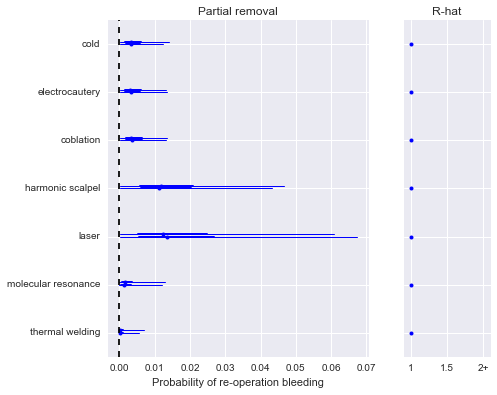

In [37]:
forestplot(reoperation_trace[1000:], varnames=['π_partial'], ylabels=technique_includes, 
           main='Partial removal', xtitle='Probability of re-operation bleeding');

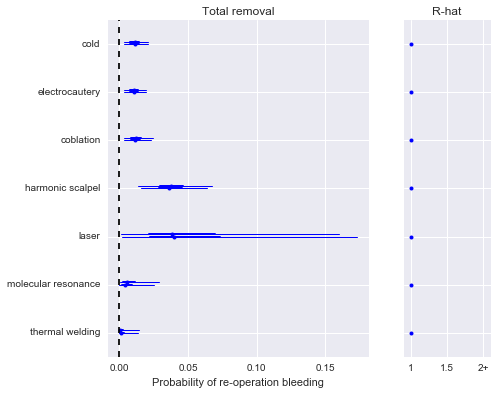

In [38]:
forestplot(reoperation_trace[1000:], varnames=['π_total'], ylabels=technique_includes, 
           main='Total removal', xtitle='Probability of re-operation bleeding');

In [39]:
summary(reoperation_trace[1000:], varnames=['π_total', 'π_partial'])


π_total:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.012            0.005            0.000            [0.003, 0.021]
  0.011            0.004            0.000            [0.003, 0.019]
  0.012            0.006            0.000            [0.003, 0.024]
  0.039            0.014            0.001            [0.015, 0.066]
  0.057            0.053            0.002            [0.002, 0.171]
  0.008            0.010            0.000            [0.000, 0.027]
  0.003            0.007            0.000            [0.000, 0.014]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.004          0.008          0.011          0.014          0.023
  0.004          0.008          0.010          0.013          0.021
  0.004          0.008          0.011          0.015          0.027
  0.017 

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Estimate of high risk of bias effect, which includes zero within the high density revion of the posterior distribution, suggesting no systematic influence of papers deemed to have high risk of bias.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119bdb3c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11abecf28>]], dtype=object)

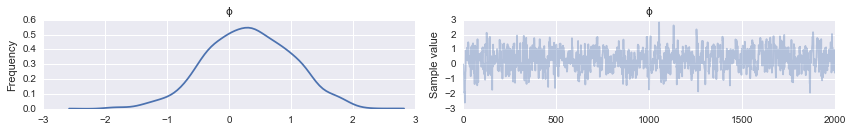

In [44]:
traceplot(reoperation_trace, varnames=['ϕ'])

In [45]:
summary(reoperation_trace, varnames=['ϕ'])


ϕ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.326            0.694            0.029            [-0.844, 1.854]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.057         -0.157         0.315          0.822          1.693



/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


## Readmission Bleeding Results

Posterior traces and histograms of surgical technique bleeding estimates for partial (top plot) and total (bottom plot) removal.

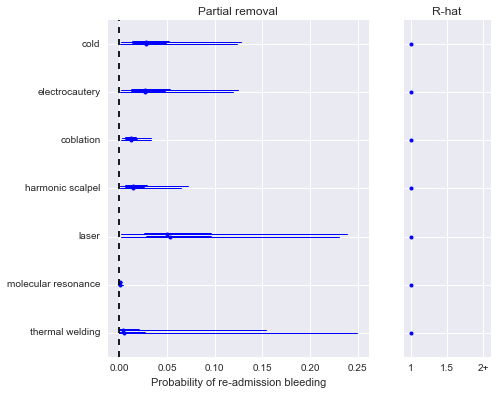

In [40]:
forestplot(readmission_trace[1000:], varnames=['π_partial'], ylabels=technique_includes, 
           main='Partial removal', xtitle='Probability of re-admission bleeding');

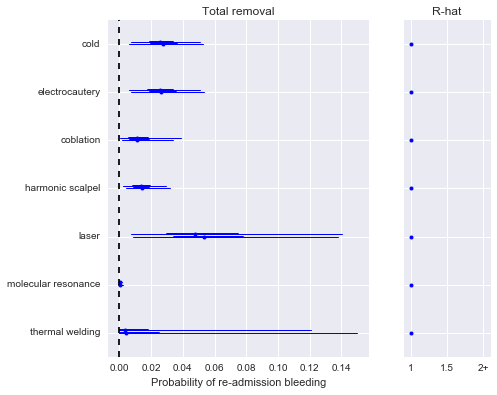

In [41]:
forestplot(readmission_trace[1000:], varnames=['π_total'], ylabels=technique_includes, 
           main='Total removal', xtitle='Probability of re-admission bleeding');

In [42]:
summary(readmission_trace[1000:], varnames=['π_total', 'π_partial'])


π_total:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.028            0.012            0.001            [0.008, 0.053]
  0.027            0.012            0.001            [0.006, 0.052]
  0.014            0.012            0.000            [0.001, 0.036]
  0.015            0.008            0.000            [0.003, 0.030]
  0.060            0.042            0.001            [0.008, 0.140]
  0.000            0.001            0.000            [0.000, 0.002]
  0.027            0.067            0.002            [0.000, 0.141]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.010          0.019          0.027          0.035          0.058
  0.009          0.018          0.026          0.035          0.058
  0.002          0.006          0.011          0.018          0.047
  0.004 

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Estimate of high risk of bias effect, which includes zero within the high density revion of the posterior distribution, suggesting no systematic influence of papers deemed to have high risk of bias.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bb454a8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11b231438>]], dtype=object)

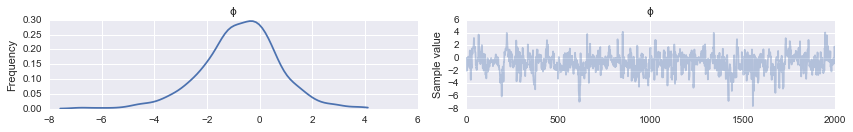

In [46]:
traceplot(readmission_trace, varnames=['ϕ'])

In [47]:
summary(readmission_trace, varnames=['ϕ'])


ϕ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.731           1.490            0.081            [-3.755, 2.243]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -3.931         -1.548         -0.641         0.195          2.118



/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


## Primary Bleeding Results

Posterior traces and histograms of surgical technique bleeding estimates for partial (top plot) and total (bottom plot) removal.

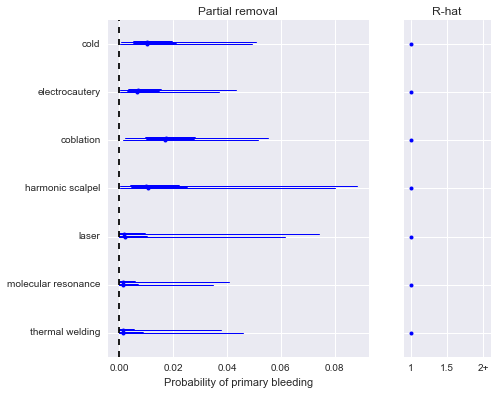

In [43]:
forestplot(primary_trace[1000:], varnames=['π_partial'], ylabels=technique_includes, 
           main='Partial removal', xtitle='Probability of primary bleeding');

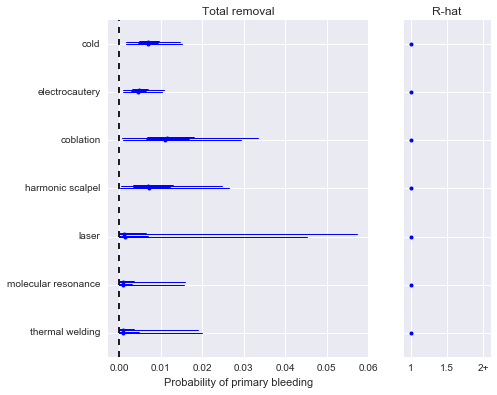

In [44]:
forestplot(primary_trace[1000:], varnames=['π_total'], ylabels=technique_includes, 
           main='Total removal', xtitle='Probability of primary bleeding');

In [45]:
summary(primary_trace[1000:], varnames=['π_total', 'π_partial'])


π_total:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.007            0.004            0.000            [0.002, 0.015]
  0.005            0.003            0.000            [0.001, 0.011]
  0.013            0.009            0.000            [0.001, 0.031]
  0.009            0.009            0.000            [0.000, 0.026]
  0.011            0.036            0.001            [0.000, 0.053]
  0.004            0.011            0.000            [0.000, 0.016]
  0.005            0.018            0.000            [0.000, 0.020]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.002          0.005          0.007          0.009          0.017
  0.001          0.003          0.005          0.007          0.012
  0.002          0.007          0.011          0.017          0.036
  0.001 

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Estimate of high risk of bias effect, which includes zero within the high density revion of the posterior distribution, suggesting no systematic influence of papers deemed to have high risk of bias.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c53f908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d0bac88>]], dtype=object)

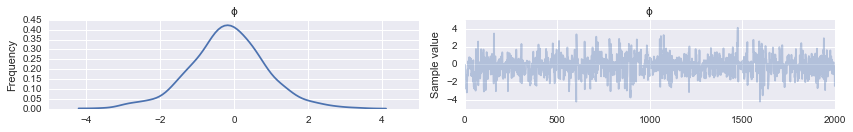

In [48]:
traceplot(primary_trace, varnames=['ϕ'])

In [49]:
summary(primary_trace, varnames=['ϕ'])


ϕ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.165           1.057            0.036            [-2.402, 2.008]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.393         -0.802         -0.157         0.476          2.026



/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


## Secondary Bleeding Results

Posterior traces and histograms of surgical technique bleeding estimates for partial (top plot) and total (bottom plot) removal.

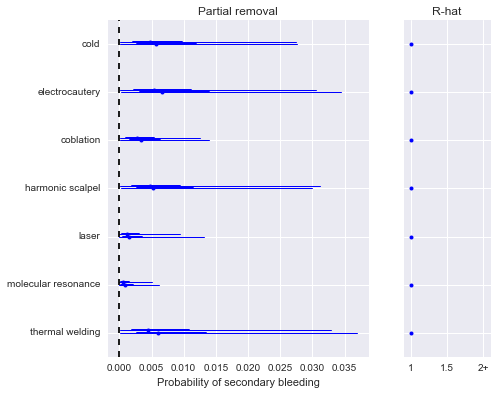

In [46]:
forestplot(secondary_trace[1000:], varnames=['π_partial'], ylabels=technique_includes, 
           main='Partial removal', xtitle='Probability of secondary bleeding');

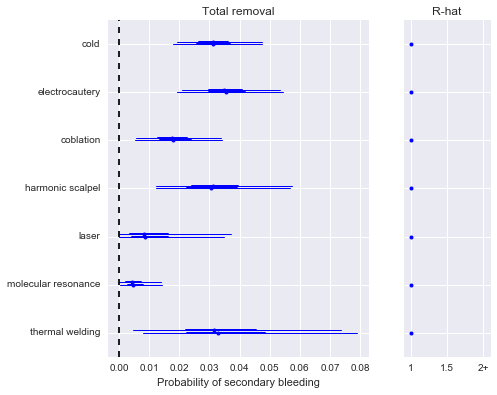

In [47]:
forestplot(secondary_trace[1000:], varnames=['π_total'], ylabels=technique_includes, 
           main='Total removal', xtitle='Probability of secondary bleeding');

In [48]:
summary(secondary_trace[1000:], varnames=['π_total', 'π_partial'])


π_total:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.032            0.008            0.000            [0.019, 0.047]
  0.036            0.009            0.000            [0.020, 0.054]
  0.019            0.008            0.000            [0.006, 0.034]
  0.032            0.012            0.000            [0.012, 0.057]
  0.012            0.012            0.000            [0.000, 0.035]
  0.006            0.004            0.000            [0.000, 0.014]
  0.037            0.021            0.001            [0.008, 0.079]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.019          0.026          0.031          0.036          0.049
  0.021          0.030          0.035          0.041          0.056
  0.007          0.013          0.018          0.023          0.038
  0.013 

/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Estimate of high risk of bias effect, which includes zero within the high density revion of the posterior distribution, suggesting no systematic influence of papers deemed to have high risk of bias.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c5d90b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11b9e6cc0>]], dtype=object)

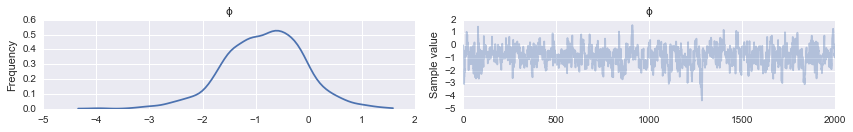

In [50]:
traceplot(secondary_trace, varnames=['ϕ'])

Estimate of high bias effect

In [51]:
summary(secondary_trace, varnames=['ϕ'])


ϕ:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.838           0.750            0.037            [-2.319, 0.664]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.425         -1.340         -0.795         -0.327         0.605



/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


## Goodness of fit

Plots of Bayesian p-values. An excess of very large or very small values may suggest lack of fit.

In [53]:
from pymc3 import sample_ppc

ppc = [sample_ppc(trace, model=model, samples=500) for trace,model in ([reoperation_trace, reoperation_model],
                                                                      [readmission_trace, readmission_model],
                                                                      [primary_trace, primary_model],
                                                                      [secondary_trace, secondary_model])]

In [94]:
bayes_p = lambda sim, true: [(s > t).mean() for s,t in zip(sim, true)]

In [95]:
obs_sim = [p['obs'] for p in ppc]
p_values = [bayes_p(simdata, model.obs.tag.test_value) for simdata,model in zip(obs_sim, 
                                        [reoperation_model, readmission_model, primary_model, secondary_model])]  

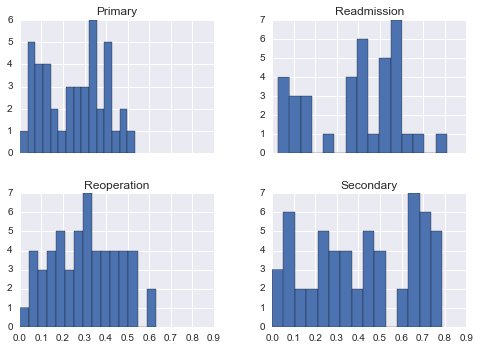

In [103]:
dfp = pd.DataFrame(p_values).T
dfp.columns = 'Reoperation', 'Readmission', 'Primary', 'Secondary'
dfp.hist(sharex=True, bins=15);

# References

1.	Hoffman MD, Gelman A. The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research. 2014;15(1):1593-1623.
2.	Gelman A, Rubin DB. Inference from iterative simulation using multiple sequences. Statist Sci. 1992:457-472.
3.	Gelman A, Carlin JB, Stern HS, Dunson DB, Vehtari A, Rubin DB. Bayesian Data Analysis, Third Edition. CRC Press; 2013.